# Intrusion Detection

## Autore
* **Torroni Alessio** 0365661

# Introduzione 
Questo Notebook si pone come obiettivo di effettuare un'analisi di molteplici modelli di Machine Learning da applicare al dataset "KDDTrainClean.csv" con il fine di classificare i flussi di rete in modo binario (normale / attacco). Il dataset NSL-KDD rappresenta un benchmark per sistemi di Intrusion Detection. Il dataset contiene informazioni sui flussi di traffico di rete verso una infrastruttura IT. Ciascun flusso `e etichettato come “normale” o associato ad una tipologia di attacco. La colonna label del dataset rappresenta l’etichetta.


# Librerie importate

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelBinarizer, TargetEncoder
from sklearn.pipeline import Pipeline

# Caricamento del Dataset 

In [237]:
# Percorso del file
file_path = 'KDDTrainClean.csv'

# Carico il dataset in un DataFrame
df = pd.read_csv(file_path)
print("Dataset caricato con successo.")
print(f"Dimensioni del dataset: {df.shape}")

# Split label in y
X = df.drop('label', axis=1)
y = df['label']

# Trasformazione della variabile target in binaria
y_binary = (y != "normal").astype(int)

# Visualizzo le prime righe del dataset
df.head()


Dataset caricato con successo.
Dimensioni del dataset: (125973, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# Descrizione delle colonne del dataset NSL-KDD

### Caratteristiche di Base
1. **duration:** Durata della connessione in secondi. Utile per rilevare attacchi come DoS, che spesso hanno durate anormalmente brevi o molto lunghe.
2. **protocol_type:** Tipo di protocollo (es. TCP, UDP, ICMP). Alcuni attacchi sfruttano protocolli specifici, come UDP o ICMP.
3. **service:** Tipo di servizio di rete (es. HTTP, FTP, DNS). Aiuta a identificare attacchi mirati a servizi critici, come FTP brute force o HTTP DoS.
4. **flag:** Stato del flag TCP (es. SF, REJ). Modifiche anomale nei flag TCP possono indicare scan di porte.
5. **src_bytes:** Numero di byte inviati dalla sorgente alla destinazione. Valori estremi possono indicare traffico anomalo.
6. **dst_bytes:** Numero di byte inviati dalla destinazione alla sorgente. Sovraccarichi di dati o risposte bloccate sono indicatori di attacco.
7. **land:** Booleano che indica se la sorgente e la destinazione sono lo stesso host. Utile per identificare land attacks.
8. **wrong_fragment:** Numero di frammenti errati nei pacchetti. Attacchi DoS o MITM possono generare frammenti malformati per manipolare il traffico.
9. **urgent:** Numero di pacchetti urgenti nel traffico. Rileva attacchi che abusano del flag URG.
10. **hot:** Numero di indicatori "caldi" in una connessione. Un valore elevato può indicare comportamenti sospetti.
11. **num_failed_logins:** Numero di tentativi di login falliti. Utile per rilevare attacchi brute force.
12. **logged_in:** Booleano che indica se il login è riuscito. Attacchi spesso mostrano tentativi di login non autorizzati.
13. **num_compromised:** Numero di indicatori compromessi in una connessione. Un valore elevato può suggerire che un attacco ha avuto successo.
14. **root_shell:** Booleano che indica se è stato ottenuto accesso root. Accessi root non autorizzati sono chiari segnali di attacco.
15. **su_attempted:** Numero di tentativi di comando `su`(switch user). Rileva attacchi di escalation di privilegi.
16. **num_root:** Numero di accessi root nella connessione. Utile per identificare compromissioni di sistema.
17. **num_file_creations:** Numero di file creati nella sessione. Malware spesso crea file temporanei o modifica il file system.
18. **num_shells:** Numero di shell ottenute nella sessione. Utile per rilevare exploit di sistema.
19. **num_access_files:** Numero di file critici aperti. Rileva accessi sospetti a file riservati.
20. **num_outbound_cmds:** Numero di comandi outbound.
21. **is_host_login:** Booleano che indica login come host.
22. **is_guest_login:** Booleano che indica login come guest.
23. **count:** Numero di connessioni alla stessa destinazione nella finestra temporale. Attacchi come port scan mostrano valori anomali.
24. **srv_count:** Numero di connessioni allo stesso servizio nella finestra temporale. Rileva attacchi mirati contro un servizio specifico.
25. **serror_rate:** Percentuale di connessioni con errori SYN. Utile per rilevare SYN flood.
26. **srv_serror_rate:** Percentuale di errori SYN verso un singolo servizio. Indicativo di attacchi specifici al servizio.
27. **rerror_rate:** Percentuale di connessioni con errori RST. Aiuta a identificare attacchi che generano reset anomali.
28. **srv_rerror_rate:** Percentuale di errori RST verso un singolo servizio. Utile per rilevare attacchi mirati.
29. **same_srv_rate:** Percentuale di connessioni alla stessa destinazione. Cambiamenti drastici possono suggerire comportamenti anomali.
30. **diff_srv_rate:** Percentuale di connessioni verso destinazioni diverse. Un aumento potrebbe indicare scanning di rete.
31. **srv_diff_host_rate:** Percentuale di connessioni a host diversi nello stesso servizio. Utile per rilevare attacchi distribuiti.
32. **dst_host_count:** Numero di connessioni alla destinazione. Una frequenza elevata può indicare un attacco mirato.
33. **dst_host_srv_count:** Numero di connessioni al servizio specifico della destinazione. Utile per rilevare attacchi contro un servizio.
34. **dst_host_same_srv_rate:** Percentuale di connessioni alla stessa destinazione nello stesso servizio. Utile per rilevare abusi di un servizio.
35. **dst_host_diff_srv_rate:** Percentuale di connessioni verso diversi servizi della stessa destinazione. Rileva attacchi a più servizi.
36. **dst_host_same_src_port_rate:** Percentuale di connessioni dalla stessa porta sorgente. Utile per individuare attacchi che sfruttano una porta specifica.
37. **dst_host_srv_diff_host_rate:** Percentuale di connessioni al servizio provenienti da host diversi. Utile per identificare botnet o attacchi distribuiti.
38. **dst_host_serror_rate:** Percentuale di errori SYN sulla destinazione. Cruciale per rilevare SYN flood.
39. **dst_host_srv_serror_rate:** Percentuale di errori SYN sul servizio della destinazione. Indicativo di attacchi mirati.
40. **dst_host_rerror_rate:** Percentuale di errori RST sulla destinazione. Utile per rilevare reset generati da attacchi.
41. **dst_host_srv_rerror_rate:** Percentuale di errori RST sul servizio della destinazione. Utile per identificare attacchi specifici al servizio.

### Etichetta
42. **label:** Indica se il flusso è normale (`normal`) o associato a un attacco (qualsiasi altro valore).


# Pre-processamento dei dati

### Colonne ad alto indice di Correlazione
Notiamo come alcune colonne nel dataset siano altamente correlate tra loro, presentando un coefficiente di correlazione superiore alla soglia di 0.95. Queste relazioni indicano che le feature coinvolte forniscono informazioni ridondanti, poiché rappresentano lo stesso comportamento o fenomeno. Ad esempio, colonne come `serror_rate` e `srv_serror_rate` spesso mostrano valori quasi identici, dato che misurano errori simili in contesti leggermente diversi. Mantenere colonne altamente correlate comporta un aumento della complessità del modello, che si traduce in una maggiore dimensionalità e in un rallentamento del processo di addestramento. Inoltre la presenza di feature altamente correlate può rendere difficile determinare quale feature contribuisca realmente alla predizione e destabilizzando il modello. 
Eliminare queste colonne ridondanti semplifica il modello, rendendolo più veloce da addestrare e più stabile. 

### Colonne a valori costanti 
Parallelamente, individuiamo colonne costanti che non aggiungono alcuna variabilità al dataset. Queste colonne, avendo lo stesso valore per tutti i record, non influenzano il processo decisionale del modello e possono essere considerate inutili. Mantenere colonne costanti comporta un aumento della dimensionalità del dataset senza alcun beneficio informativo, oltre a rappresentare uno spreco di risorse computazionali, incrementando i tempi di addestramento e il consumo di memoria. Al contrario, rimuovere le feature costanti riduce la dimensionalità e velocizza i calcoli, senza alcuna perdita di informazione, poiché non aggiungono variabilità significativa al dataset.

Questa attività di preprocessamento garantisce che il dataset sia ottimizzato per l'addestramento, mantenendo solo le feature più rilevanti e significative, migliorando così sia l'efficienza del modello che la sua capacità di generalizzazione.

### Calcolo della matrice di Correlazione  

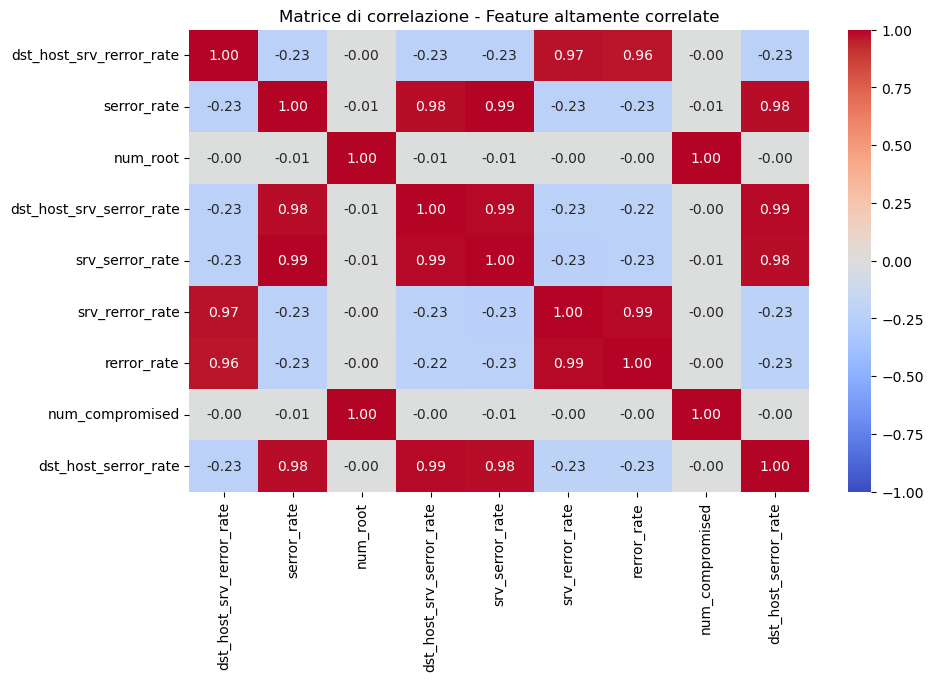

Coppie di colonne altamente correlate in formato tabellare con percentuale di correlazione:


,Feature 1,Feature 2,Correlation Index
0,num_compromised,num_root,99.883345
1,serror_rate,srv_serror_rate,99.328924
2,serror_rate,dst_host_serror_rate,97.937308
3,serror_rate,dst_host_srv_serror_rate,98.113896
4,srv_serror_rate,dst_host_serror_rate,97.759601
5,srv_serror_rate,dst_host_srv_serror_rate,98.625172
6,rerror_rate,srv_rerror_rate,98.900765
7,rerror_rate,dst_host_srv_rerror_rate,96.444867
8,srv_rerror_rate,dst_host_srv_rerror_rate,97.020800
9,dst_host_serror_rate,dst_host_srv_serror_rate,98.505222


In [146]:

# Calcolo la matrice di correlazione
correlation_matrix = X.corr(numeric_only=True)
highly_correlated_pairs = []
threshold = 0.95

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((
                correlation_matrix.index[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Visualizzo le coppie altamente correlate in un grafico
plt.figure(figsize=(10, 6))
correlated_features = list(set([item for sublist in highly_correlated_pairs for item in sublist[:2]]))
correlation_matrix_filtered = correlation_matrix.loc[correlated_features, correlated_features]
sns.heatmap(correlation_matrix_filtered, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title("Matrice di correlazione - Feature altamente correlate")
plt.show()

# Visualizzazione delle coppie altamente correlate in formato tabellare
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation Index'])
correlated_df['Correlation Index'] = correlated_df['Correlation Index'].abs() * 100  # Converto in percentuale
print("Coppie di colonne altamente correlate in formato tabellare con percentuale di correlazione:")
correlated_df.head(10)


## Rimozione delle feature costanti ed altamente correlate 
Analizzando le feature dalla matrice di correlazione, controlliamo quanto sono correlate con la feature target. Notiamo che le coppie più correlate hanno coefficienti di correlazione con il target molto simili. Per questo, scegliamo di rimuovere la feature con il coefficiente di correlazione più basso rispetto al target.

In [239]:
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
print("Feature rimosse perché costanti:", constant_columns)
X = X.drop(columns=constant_columns)
# Rimuovere le feature altamente correlate
features_to_remove = []
features_to_print = []
visited = set()
correlation_with_target = X.corrwith(y_binary,numeric_only=True).sort_values(ascending=False)
for feature1, feature2, _ in highly_correlated_pairs:  # Ignoro il terzo valore (correlation index)
    if feature1 not in visited and feature2 not in visited:
        # Confronto i coefficienti di correlazione con il target
        corr_feature1 = correlation_with_target[feature1]
        corr_feature2 = correlation_with_target[feature2]

        # Decido quale feature rimuovere: mantengo quella con correlazione più alta con il target
        if abs(corr_feature1) >= abs(corr_feature2):  # Preferisco il valore più alto in valore assoluto
            features_to_remove.append(feature2)
            features_to_print.append(feature1)
        else:
            features_to_remove.append(feature1)
            features_to_print.append(feature2)

        visited.add(feature1)
        visited.add(feature2)
        
    
# Visualizzo la correlazione in formato tabellare
correlation_df = correlation_with_target.reset_index()
correlation_df.columns = ['Feature', 'Corr with Target']
selected_features = correlation_df[correlation_df['Feature'].isin(features_to_print)]
remove_features = correlation_df[correlation_df['Feature'].isin(features_to_remove)]


print(selected_features)
print(remove_features)

print("Feature rimosse per alta correlazione:", features_to_remove)
X = X.drop(columns=features_to_remove)

Feature rimosse perché costanti: ['num_outbound_cmds']
                     Feature  Corr with Target
0   dst_host_srv_serror_rate          0.654985
2                serror_rate          0.650652
6            srv_rerror_rate          0.253504
25                  num_root         -0.011452
                 Feature  Corr with Target
1   dst_host_serror_rate          0.651842
3        srv_serror_rate          0.648289
8            rerror_rate          0.253397
24       num_compromised         -0.010198
Feature rimosse per alta correlazione: ['num_compromised', 'srv_serror_rate', 'rerror_rate', 'dst_host_serror_rate']


# Divisione del Dataset 
Quando si valuta un modello di Machine Learning, l'intero data set deve essere scomposto in 3 parti:

* **training set**: porzione del data set utilizzata per addestrare il modello;
* **validation set**: porzione del data set utilizzata per stabilire quali sono i valori degli iperparametri che portano il modello ad avere le prestazioni migliori.
* **testing set**: porzione del data set utilizzata per effettuare le predizioni, confrontare il valore vero col valore predetto del target di ciascun elemento e calcolare le prestazioni e la qualità del modello.

Stando alla documentazione di Sklearn, il data set viene tipicamente suddiviso secondo il seguente schema:

* Si ha una prima suddivisione statica in training+validation set e testing set: circa il 70-80% delle istanze andrebbe nel training+validation set, mentre il restante 20-30% andrebbe nel testing set. In questo progetto, verrà effettuata una suddivisione del tipo: 80% dei dati nel training+validation set; 20% dei dati nel testing set.
* Per quanto riguarda il training+validation set, nel caso in cui si ha a che fare con un modello che prevede il settaggio di qualche iperparametro, è necessario un meccanismo per applicare un'ulteriore suddivisione in training set e validation set. Questa seconda suddivisione avviene sulla base della k-fold cross validation: il training+validation set viene diviso in  orzioni uguali e vengono effettuate iterazioni, in ciascuna delle quali una sola porzione (diversa a ogni iterazione) svolge il ruolo di validation set, mentre le altre svolgono il ruolo di training set.

Si è scelto di effettuare la divisione del dataset prima della normalizzazione dei dati per evitare problemi di **data leakage** ovvero l'inclusione accidentale di informazioni dal test set , che altera i risultati e porta a modelli non generalizzabili, poiché il modello impara da dati che non avrebbe normalmente accesso durante la predizione

In [124]:
from sklearn.model_selection import train_test_split

# Suddivisione iniziale: 80% training+validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, shuffle=True)

# Suddivisione del training+validation in 75% training, 25% validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True)


### Controllo che la distribuzione delle classi sia bilanciata 

Distribuzione classi nel Training Set:
label
0    0.535239
1    0.464761
Name: proportion, dtype: float64


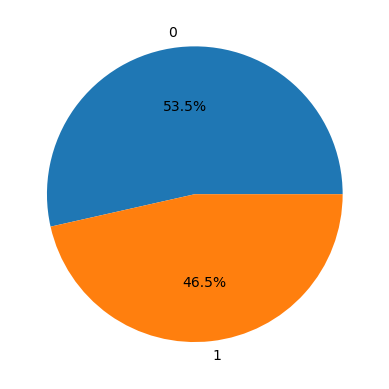


Distribuzione classi nel Validation Set:
label
0    0.534471
1    0.465529
Name: proportion, dtype: float64


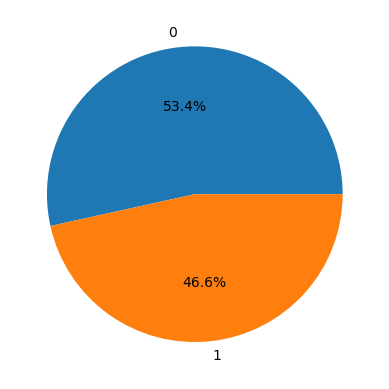


Distribuzione classi nel Test Set:
label
0    0.532725
1    0.467275
Name: proportion, dtype: float64


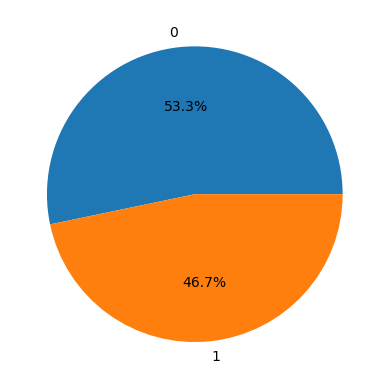

In [46]:
# Funzione per controllare la distribuzione delle classi
def verifica_bilanciamento(y, set_name):
    distribuzione = y.value_counts(normalize=True)
    print(f"Distribuzione classi nel {set_name} Set:")
    print(distribuzione)
    plt.pie(np.array(distribuzione),labels=[0,1],autopct='%1.1f%%')
    plt.show()
    print()

# Verifica per ogni set
verifica_bilanciamento(pd.Series(y_train), "Training")
verifica_bilanciamento(pd.Series(y_val), "Validation")
verifica_bilanciamento(pd.Series(y_test), "Test")


# Normalizzazione delle feature 

Affinché tutte le feature diano lo stesso contributo nell'apprendimento dei modelli di Machine Learning, è necessario che i loro valori viaggino sullo stesso ordine di grandezza. Invece noi abbiamo:

* **duration**: assume valori tra 0 e 42908
* **src_bytes**: assume valori tra 0 e 1379963888
* **dst_bytes**: assume valori tra 0 e 1309937401
* **num_compromised**: assume valori tra 0 e 7479
* **num_root**: assume valori tra 0 e 7468
* **count**: assume valori tra 0 e 511
* **srv_count**: assume valori tra 0 e 511
* **dst_host_count**: assume valori tra 0 e 255
* **dst_host_srv_count**: assume valori tra 0 e 255

per quanto riguarda le feature categoriche abbiamo:

* **protocol_type**: 'tcp','udp','icmp' 
* **service**: come vediamo qui di seguito assume 70 valori unici	
* **flag**: 'SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH'
* **label**: nel caso generico assume piu di due valori. Siccome il nostro obbiettivo è una classificazione binaria normalizziamo la feature ponendo
0 se il flusso è normale e 1 se è un attacco.

In [11]:
# Creare una lista di feature numeriche non binarie
high_order_features = [
    col for col in X.columns
    if X[col].dtype in ['int64', 'float64'] and X[col].max() > 1
]

# Calcolare Min e Max per queste feature
min_max_high_order = X[high_order_features].agg(['min', 'max'])

print("\nValori Min e Max per le feature con ordine di grandezza maggiore di 1:")
min_max_high_order.head()




Valori Min e Max per le feature con ordine di grandezza maggiore di 10^0:


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_file_creations,num_shells,num_access_files,count,srv_count,dst_host_count,dst_host_srv_count
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
max,42908,1379963888,1309937401,3,3,77,5,7479,2,43,2,9,511,511,255,255


# scrivere speigazione pipeline

In [ ]:
# Classe personalizzata per il calcolo del rapporto tra src_bytes e dst_bytes
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, src_bytes_ix, dst_bytes_ix):
        self.src_bytes_ix = src_bytes_ix
        self.dst_bytes_ix = dst_bytes_ix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calcola il rapporto tra src_bytes e dst_bytes evitando divisioni per 0
        src_dst_ratio = X[:, self.src_bytes_ix] / (X[:, self.dst_bytes_ix] + 1e-9)
        return np.c_[X, src_dst_ratio]


# Identificazione delle colonne numeriche e categoriche
num_attribs_high_range = ["duration", "src_bytes", "dst_bytes", "hot", "num_compromised", "num_file_creations", "count", "srv_count", "dst_host_count", "dst_host_srv_count"]  # Feature da normalizzare con ordine di grandezza maggiore di 10^1
num_attribs_low_range = ["wrong_fragment", "urgent","num_failed_logins","su_attempted", "num_shells", "num_access_files"]  # Feature da normalizzare per modelli sensibili alle scale valori massimi compresi tra 1 e 10 
cat_attribs = ["protocol_type", "flag"]  # Feature categoriche con dimensionalità contenuta
cat_attribs_high_dim = [ "service"] # Feature categoriche con dimensionalita 

# Indici delle colonne per la trasformazione personalizzata
src_bytes_ix = X.columns.get_loc("src_bytes")
dst_bytes_ix = X.columns.get_loc("dst_bytes")

# Pipeline per la normalizzazione delle feature numeriche con range alto
num_pipeline_high_range = Pipeline([
    ("attribs_adder", CombinedAttributesAdder(src_bytes_ix, dst_bytes_ix)),  # Aggiunta di feature derivate
    ("scaler", MinMaxScaler()),  # Normalizzazione tra 0 e 1
])

# Pipeline per le feature numeriche con range basso (0-3, 0-5, ecc.)
num_pipeline_low_range = Pipeline([
    ("scaler", MinMaxScaler()),  # Normalizzazione tra 0 e 1 per uniformare i dati
])

# Pipeline per modelli insensibili alla scala (Random Forest e AdaBoost)
no_scaling_pipeline = Pipeline([
    ("attribs_adder", CombinedAttributesAdder(src_bytes_ix, dst_bytes_ix)),  # Aggiunta di feature derivate
    ("passthrough", "passthrough")  # Nessuna normalizzazione applicata
])

# Pipeline completa per il preprocessing delle feature
# Qui si include la gestione delle feature categoriche, che saranno normalizzate allo stesso modo per tutti i modelli
full_pipeline_models = {
    "Feedforward_NN": ColumnTransformer([
        ("num_high", num_pipeline_high_range, num_attribs_high_range),   # Normalizza feature con range alto
        ("num_low" , num_pipeline_low_range, num_attribs_low_range),     # Normalizza feature con range basso
        ("cat_oht" , OneHotEncoder(), cat_attribs),                      # Gestione delle feature categoriche con OneHotEncoder
        ("cat_tge" , TargetEncoder(), cat_attribs_high_dim),             # Gestione delle feature categoriche ad alta dimensionalità con Target Encoder
    ]),
    "KNN": ColumnTransformer([
       ("num_high" , num_pipeline_high_range, num_attribs_high_range),    # Normalizza feature con range alto
        ("num_low" , num_pipeline_low_range, num_attribs_low_range),      # Normalizza feature con range basso
        ("cat_oht" , OneHotEncoder(), cat_attribs),                       # Gestione delle feature categoriche con OneHotEncoder
        ("cat_tge" , TargetEncoder(), cat_attribs_high_dim),              # Gestione delle feature categoriche ad alta dimensionalità con Target Encoder
    ]),
    "Logistic_Regression": ColumnTransformer([
        ("num_high", num_pipeline_high_range, num_attribs_high_range),   # Normalizza feature con range alto
        ("num_low" , num_pipeline_low_range, num_attribs_low_range),     # Normalizza feature con range basso
        ("cat_oht" , OneHotEncoder(), cat_attribs),                      # Gestione delle feature categoriche con OneHotEncoder
        ("cat_tge" , TargetEncoder(), cat_attribs_high_dim),             # Gestione delle feature categoriche ad alta dimensionalità con Target Encoder
    ]),
    "Random_Forest": ColumnTransformer([
        ("num_high", no_scaling_pipeline, num_attribs_high_range),       # Nessuna normalizzazione per modelli ad albero
        ("num_low" , no_scaling_pipeline, num_attribs_low_range), 
        ("cat_oht" , OneHotEncoder(), cat_attribs),
        ("cat_tge" , TargetEncoder(), cat_attribs_high_dim),             # Gestione delle feature categoriche ad alta dimensionalità con Target Encoder

    ]),
    "AdaBoost": ColumnTransformer([
        ("num_high", no_scaling_pipeline, num_attribs_high_range),
        ("num_low" , no_scaling_pipeline, num_attribs_low_range),
        ("cat_oht" , OneHotEncoder(), cat_attribs),
        ("cat_tge" , TargetEncoder(), cat_attribs_high_dim),              # Gestione delle feature categoriche ad alta dimensionalità con Target Encoder

    ])
}

# Nota finale: Le pipeline sono configurate per ogni modello secondo le loro esigenze
# - Feedforward NN, KNN, Logistic Regression: Richiedono normalizzazione
# - Random Forest, AdaBoost: Non richiedono normalizzazione
# - Feature categoriche: OneHotEncoder applicato a tutti i modelli per consistenza
